In [24]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import os

In [25]:
data = {"images": [], "labels": [], "filenames": []}
dataset_path = os.path.join(os.getcwd(), "datasets/tally_marks")

for subdir in os.listdir(dataset_path):
    current_path = os.path.join(dataset_path, subdir)
    for file in os.listdir(current_path):
        if file[-3:] == "jpg":
            image_data = imread(os.path.join(current_path, file))
            data["images"].append(image_data)
            data["labels"].append(subdir)
            data["filenames"].append(file)

31904
31904
(24, 30)


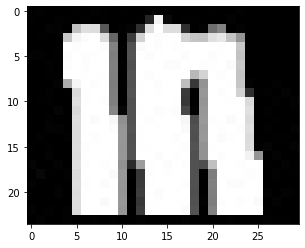

In [31]:
print(len(data["images"]))
print(len(data["labels"]))
print(data["images"][0].shape) #each image should be 24x30
plt.imshow(data["images"][17543], cmap="gray") #display an example image

In [45]:
X = np.array(data["images"])
y = np.array(data["labels"])

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [48]:
#test using np.reshape to flatten the array
X_transformed = X.reshape(len(X), len(X[0])*len(X[0][0]))
#print(X_transformed[0])
print(len(X_transformed[0])) #should be 720 (24*30)


[  0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0   3
   0   0   1   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   4   0   3 190 254 255 189   0   1   0   3   1   2   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1
 200 243 255 251 193   1   0   2   0   0   0   3   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   1   0   0 255 253 255 255 233 167
   1   1   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1   0   3   0 255 255 251 254 254 255   0   1   0   1   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 255 253 255 255 255 251   2   0   1   4   0   2   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   2   0   2   1 255 254 253 255 255 255
   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   3   0   1 254 255 255 254 254 255   0   1   0   2   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [53]:
#create custom pipeline to flatten the arrays...
from sklearn.base import BaseEstimator, TransformerMixin

class FlattenImage(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.reshape(len(X), 24*30) #len(X[0])*len(X[0][0])

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

svm_clf = Pipeline([
    ("flatten", FlattenImage()),
    ("scaler", StandardScaler()),
    ("svm", SVC(C=1, kernel="rbf", gamma="scale"))
])

svm_clf.fit(X_train, y_train)


Pipeline(steps=[('flatten', FlattenImage()), ('scaler', StandardScaler()),
                ('svm', SVC(C=1))])

In [70]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv=3)

In [71]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[4959,   35,    0,    0,    1],
       [  52, 4749,   23,    5,    8],
       [   0,   72, 4484,   36,   53],
       [   0,    4,   91, 4167,  191],
       [   0,   11,   60,   82, 6440]])

In [75]:
from sklearn.model_selection import cross_val_score
cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy") #compute the accuracy of the binary classifier on three folds from the training set

array([0.97132111, 0.9722614 , 0.97131774])

In [76]:
svm_clf.score(X_test, y_test)

0.9752389907538004

In [77]:
y_test_hat = svm_clf.predict(X_test)
confusion_matrix(y_test, y_test_hat)

array([[1240,    5,    0,    0,    0],
       [   8, 1191,    4,    2,    2],
       [   0,   17, 1111,   11,   12],
       [   0,    0,   26, 1077,   40],
       [   0,    4,   12,   15, 1604]])

Preicteded this image was 2 but it's actually 5


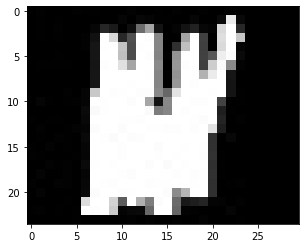

In [95]:
#get an image of an instance where the model failed 
incorrect_classifications = []
for i in range(len(y_test)):
    if y_test_hat[i] != y_test[i]:
        incorrect_classifications.append(i)

index = 42
print("Preicteded this image was", y_test_hat[incorrect_classifications[index]], "but it's actually", y_test[incorrect_classifications[index]])
plt.imshow(X_test[incorrect_classifications[index]], cmap="gray")